In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, SeparableConv2D
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13668937403658078896
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10919644256982386974
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Xception

## A discussion on separable convolution and variants

* The spatial separable convolution is so named because it deals primarily with the spatial dimensions of an image and kernel: the width and the height

* A spatial separable convolution simply divides a kernel into two, smaller kernels. The most common case would be to divide a 3x3 kernel into a 3x1 and 1x3 kernel, like so:

![](https://miro.medium.com/max/1400/1*mL53fW0tJpNWEePp54y1Sg.png)

* Now, instead of doing one convolution with 9 multiplications, we do two convolutions with 3 multiplications each (6 in total) to achieve the same effect. With less multiplications, computational complexity goes down, and the network is able to run faster.

![](https://miro.medium.com/max/1400/1*o3mKhG3nHS-1dWa_plCeFw.png)

* The main issue with the spatial separable convolution is that not all kernels can be “separated” into two, smaller kernels.

## Depthwise separable conv

* Unlike spatial separable convolutions, **depthwise separable convolutions** work with kernels that cannot be “factored” into two smaller kernels. Hence, it is more commonly used. 

* The depthwise separable convolution is so named because it deals not just with the spatial dimensions, but with the depth dimension 

* An input image may have 3 channels: RGB. After a few convolutions, an image may have multiple channels. You can image each channel as a particular interpretation of that image; in for example, the “red” channel interprets the “redness” of each pixel, the “blue” channel interprets the “blueness” of each pixel, and the “green” channel interprets the “greenness” of each pixel. An image with 64 channels has 64 different interpretations of that image.

* Let's consider normal 2d conv, and let us assume we only one to create one filter. Below, we end up doing 5*5*3 multiplications when we calculate ***one*** value in the feature map.

![](https://miro.medium.com/max/1400/1*fgYepSWdgywsqorf3bdksg.png)

* After going through a 5x5x3 kernel, the 12x12x3 image will become a 8x8x1 image.

* The above example was for one filter, how about more? What if we want to increase the number of channels in our output image? What if we want an output of size 8x8x256? See below.

![](https://miro.medium.com/max/1400/1*XloAmCh5bwE4j1G7yk5THw.png)

* Assuming we now want to create a feature map with a depth of 256, how many multiplications will we perform for each single feature map value now?

* Introducing, depthwise separable convolution.

* Made up of two main operations: depthwise convolution and a pointwise convolution.

* Step 1: Depthwise convolution performs channel-wise $n\times n$ spatial convolution. In the image below, this will be 3 5x5x1 convolutions. This will result in 25 multiplications. Each 5x5x1 kernel iterates 1 channel of the image (note: 1 channel, not all channels), getting the scalar products of every 25 pixel group, giving out a 8x8x1 image. Stacking these images together creates a 8x8x3 image

![](https://miro.medium.com/max/1400/1*yG6z6ESzsRW-9q5F_neOsg.png)



* Step 2: pointwise convolution (aka 1x1 conv). Remember, the original convolution transformed a 12x12x3 image to a 8x8x256 image. Currently, the depthwise convolution has transformed the 12x12x3 image to a 8x8x3 image. Now, we need to increase the number of channels of each image.

* We iterate a 1x1x3 kernel through our 8x8x3 image, to get a 8x8x1 image.

![](https://miro.medium.com/max/1400/1*37sVdBZZ9VK50pcAklh8AQ.png)

* And since we want 256 feature maps, we repeat this process 256 times. We can create 256 1x1x3 kernels that output a 8x8x1 image each to get a final image of shape 8x8x256.

![](https://miro.medium.com/max/1400/1*Q7a20gyuunpJzXGnWayUDQ.png) 

* Let’s calculate the number of multiplications the computer has to do in the original convolution. There are 256 5x5x3 kernels that move 8x8 times, each one is 3x5x5x8x8 = 4,800 multiplications. So far 256 filters, that’s 256x3x5x5x8x8=1,228,800 multiplications.

* What about the separable convolution? 

* In the depthwise convolution, we have 3 5x5x1 kernels that move 8x8 times. That’s 3x5x5x8x8 = 4,800 multiplications. In the pointwise convolution, we have 256 1x1x3 kernels that move 8x8 times. That’s 256x1x1x3x8x8=49,152 multiplications. Adding them up together, that’s 53,952 multiplications.

* 52,952 is a lot less than 1,228,800. With less computations, the network is able to process more in a shorter amount of time.

## Xception (modified depthwise separable convolution)

This is what we talked about, where we first apply depthwise and then pointwise convolution:

![](https://miro.medium.com/max/1400/1*VvBTMkVRus6bWOqrK1SlLQ.png)

* The modified depthwise separable convolution is the pointwise convolution followed by a depthwise convolution. This modification is motivated by the inception module in Inception-v3 that 1×1 convolution is done first before any n×n spatial convolutions.

* In the original Inception Module, there is non-linearity after the first operation. In Xception, the modified depthwise separable convolution, there is NO intermediate ReLU non-linearity.


credits: 
 
 https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

 https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import SeparableConv2D

In [ ]:
# Define some input, with 4 tensors of 8x8x3
X = tf.random.uniform((4, 8, 8, 3))

In [ ]:
sep = SeparableConv2D(filters = 2, kernel_size = 2)

In [ ]:
sep(X).shape

TensorShape([4, 7, 7, 2])

## Entry flow

In [ ]:
inputs = Input(shape=(92,92,1))

stem = tf.keras.layers.Conv2D(
    32, kernel_size=3, strides=2, padding='same')(inputs)
stem = tf.keras.layers.BatchNormalization()(stem)
stem = tf.keras.layers.ReLU()(stem)
stem = tf.keras.layers.Conv2D(
    64, kernel_size=3, padding='same')(stem)
stem = tf.keras.layers.BatchNormalization()(stem)
stem = tf.keras.layers.ReLU()(stem)

residual = tf.keras.layers.Conv2D(128, 1, strides=2, padding='same')(stem)

block2 = SeparableConv2D(128, kernel_size = (3,3), padding='same')(stem)
block2 = tf.keras.layers.BatchNormalization()(block2)
block2 = tf.keras.layers.ReLU()(block2)
block2 = SeparableConv2D(128, kernel_size = (3,3), padding='same')(block2)
block2 = tf.keras.layers.BatchNormalization()(block2)
block2 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(block2)
block2 = tf.keras.layers.add([block2, residual])  # Add back residual

residual = tf.keras.layers.Conv2D(256, 1, strides=2, padding='same')(block2)

block3 = tf.keras.layers.ReLU()(block2)
block3 = SeparableConv2D(256, kernel_size = (3,3), padding='same')(block3)
block3 = tf.keras.layers.ReLU()(block3)
block3 = SeparableConv2D(256, kernel_size = (3,3), padding='same')(block3)
block3 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(block3)
block3 = tf.keras.layers.add([block3, residual])  # Add back residual

residual = tf.keras.layers.Conv2D(728, 1, strides=2, padding='same')(block3)

block4 = tf.keras.layers.ReLU()(block3)
block4 = SeparableConv2D(728, kernel_size = (3,3), padding='same')(block4)
block4 = tf.keras.layers.ReLU()(block4)
block4 = SeparableConv2D(728, kernel_size = (3,3), padding='same')(block4)
block4 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(block4)
block4 = tf.keras.layers.add([block4, residual])  # Add back residual
block4.shape

TensorShape([None, 6, 6, 728])

## Middle flow

In [ ]:
redidual = block4

middle1 = tf.keras.layers.Activation('relu')(block4)
middle1 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle1)
middle1 = tf.keras.layers.BatchNormalization()(middle1)

middle1 = tf.keras.layers.Activation('relu')(middle1)
middle1 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle1)
middle1 = tf.keras.layers.BatchNormalization()(middle1)

middle1 = tf.keras.layers.Activation('relu')(middle1)
middle1 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle1)
middle1 = tf.keras.layers.BatchNormalization()(middle1)
middle1 = tf.keras.layers.add([middle1, residual])  # Add back residual

###########################################################################
redidual = middle1

middle2 = tf.keras.layers.Activation('relu')(middle1)
middle2 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle2)
middle2 = tf.keras.layers.BatchNormalization()(middle2)

middle2 = tf.keras.layers.Activation('relu')(middle2)
middle2 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle2)
middle2 = tf.keras.layers.BatchNormalization()(middle2)

middle2 = tf.keras.layers.Activation('relu')(middle2)
middle2 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle2)
middle2 = tf.keras.layers.BatchNormalization()(middle2)
middle2 = tf.keras.layers.add([middle2, residual])  # Add back residual

###########################################################################
redidual = middle2

middle3 = tf.keras.layers.Activation('relu')(middle2)
middle3 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle3)
middle3 = tf.keras.layers.BatchNormalization()(middle3)

middle3 = tf.keras.layers.Activation('relu')(middle3)
middle3 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle3)
middle3 = tf.keras.layers.BatchNormalization()(middle3)

middle3 = tf.keras.layers.Activation('relu')(middle3)
middle3 = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(middle3)
middle3 = tf.keras.layers.BatchNormalization()(middle3)
middle3 = tf.keras.layers.add([middle3, residual])  # Add back residual
middle3.shape
###########################################################################

TensorShape([None, 6, 6, 728])

## Exit flow

In [ ]:
residual = tf.keras.layers.Conv2D(1024, 1, strides=2, padding='same')(middle3)

exit1 = tf.keras.layers.ReLU()(middle3)
exit1 = SeparableConv2D(728, kernel_size = (3,3), padding='same')(exit1)
exit1 = tf.keras.layers.BatchNormalization()(exit1)
exit1 = tf.keras.layers.ReLU()(exit1)
exit1 = SeparableConv2D(1024, kernel_size = (3,3), padding='same')(exit1)
exit1 = tf.keras.layers.BatchNormalization()(exit1)
exit1 = tf.keras.layers.ReLU()(exit1)

exit1 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(exit1)
exit1 = tf.keras.layers.add([exit1, residual])  # Add back residual

exit2 = SeparableConv2D(1536, kernel_size = (3,3), padding='same')(exit1)
exit2 = tf.keras.layers.BatchNormalization()(exit2)
exit2 = tf.keras.layers.ReLU()(exit2)
exit2 = SeparableConv2D(2048, kernel_size = (3,3), padding='same')(exit2)
exit2 = tf.keras.layers.BatchNormalization()(exit2)
exit2 = tf.keras.layers.ReLU()(exit2)

exit3 = tf.keras.layers.GlobalAveragePooling2D()(exit2)

output = tf.keras.layers.Dense(10, activation="softmax")(exit3)

In [ ]:
model = Model(inputs, output)

## Load the dataset

In [ ]:
# load data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

## Find the unique numbers from the train labels

In [ ]:
classes = np.unique(Y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


## Reshape needed

Keras wants to know the depth of an image. 

For CNNS, Keras wants the format of the data as follows: [batches, width, height, depth]. 

In this case the colour channel/depth of the images is 1. Currently the shape is:

But this doesn't have a depth value. So we can reshape it

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

## Convert from categorical labels to one-hot encoded vectors

In this case there are 10 classes so we can tell the function to convert into a vector of length 10

In [ ]:
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
num_classes = 10

## Small twist!

API: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
def resize_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)

    image = tf.image.resize(image, (92,92))
    return image, label

In [ ]:
train_ds = (train_ds
                  .map(resize_images)
                  .shuffle(buffer_size=10000)
                  .batch(batch_size=64, drop_remainder=True))
test_ds = (test_ds
                  .map(resize_images)
                  .batch(batch_size=32, drop_remainder=False))

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 92, 92, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 46, 46, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 46, 46, 32)  128         ['conv2d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 re_lu_12 (ReLU)                (None, 46, 46, 32)   0           ['batch_normalization_17[0]

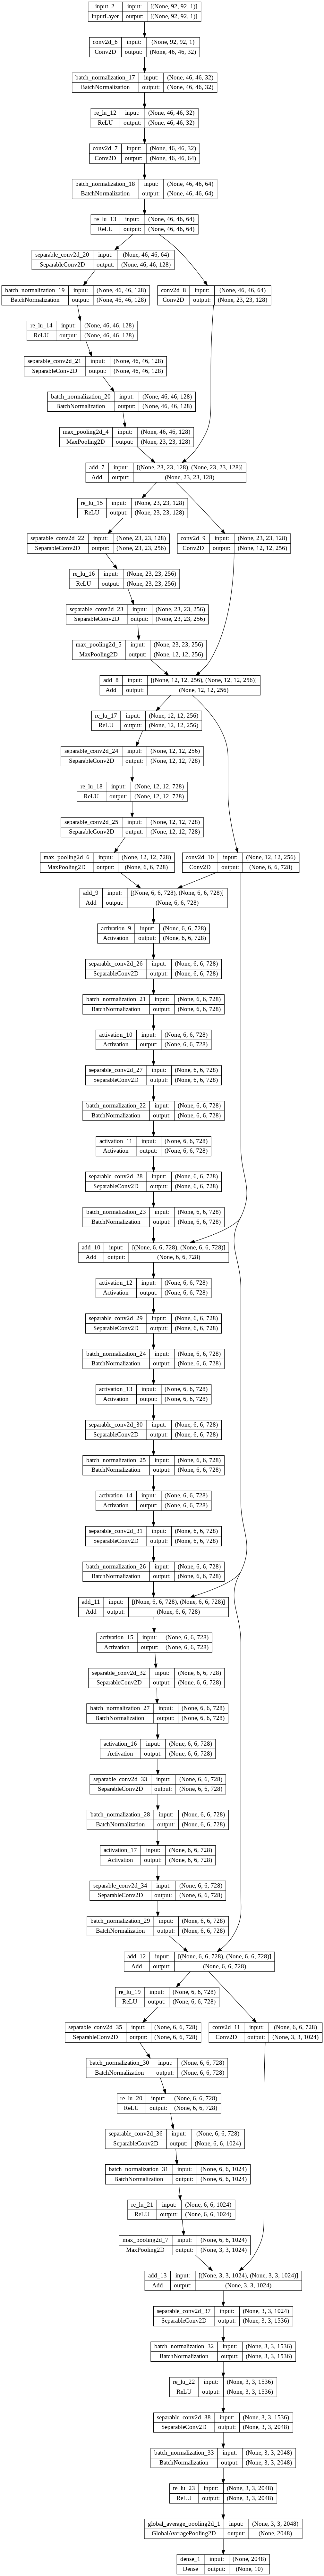

In [ ]:
tf.keras.utils.plot_model(model, "Xception.png", show_shapes=True)

## Begin training

In [ ]:
model.fit(train_ds, epochs=2, batch_size=32, verbose=1)

Epoch 1/2
937/937 [==============================] - 172s 178ms/step - loss: 0.5603 - accuracy: 0.8003
Epoch 2/2
937/937 [==============================] - 167s 177ms/step - loss: 0.3306 - accuracy: 0.8817


## Predict on all the test data

In [ ]:
predictions = model.predict(test_ds)

313/313 [==============================] - 8s 21ms/step


In [ ]:
predictions.shape

(10000, 10)

In [ ]:
correct_values = np.argmax(Y_test,axis=-1)
predicted_classes = np.argmax(predictions,axis=-1)

In [ ]:
accuracy_score(predicted_classes,correct_values)*100

86.50999999999999